In [1]:
import datetime
import joblib
import shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from lightgbm import LGBMClassifier, plot_tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer, recall_score, precision_score, accuracy_score, average_precision_score, roc_auc_score
from tqdm import tqdm 

tqdm.pandas()

In [197]:
from metrics_f1 import calc_f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Наш подход**:
- Решили использовать модель градиентного бустинга (на деревьях решений). Эта модель легко интерпретируема и достаточно гибкая. С помощью подбора гиперпараметров можно подстраивать задачу под разные условия: например, подбор с помощью GridSearch при максимизации  $F_{\beta}(\beta > 1)$ позволит учесть случай, когда издержки на пропущенный сломанный вагон высокие. Обратно, максимизация $F_{\beta}(\beta < 1)$ подходит, когда выше стоимость ошибочного отправления вагона в ремонт
- Выборка несбалансирована: менее 5% объектов относятся к положительному классу. Upsampling/downsampling не зашли, поэтому дисбаланс учитывали весами на объекты разных классов внутри бустинга.
- Признаки для модели выбирали так, чтобы их было просто посчитать и легко добавить новый объект в выборку. Также убрали признаки, которые имеют очень низкую дисперсию - например, почти все детали объектов принадлежат к одному и тому же типу - для дерева решений выборка не будет хорошо разделяться. Основные признаки посчитаны по таблице дислокаций поездов. Также добавлены признаки, относящиеся к прошлым ремонтам. 
- Так как не все признаки могут быть информативны, с помощью последовательного отбора признаков был отобран набор, максимизирующий $F_1$. Также пробовали для этого другие метрики, устойчивые к дисбалансу, но получили похожие результаты
- Подбирали порог округления: в разных случаях (возможно, в разных регионах, погодных условиях) может потребоваться изменить уровень уверенности в ответе. Максимизировали аналогично $F_1$. 

**Анализ и интерпретируемость:**
- Сразу несколько подходов отметили одинаковый набор важных характеристик. Среди них `ost_prob`, `days_since_deprep`, `days_to_planrep` и `rod_id`. Также показалось интересным влияние признака `prob_change_mean`, показывающего среднюю интенсивность перемещений. Присутствие, казалось бы, похожих по смыслу и потенциально мультиколлинеарных признаков `ost_prob` и `prob_change_mean` среди важных может показывать то, что кроме абсолютных значений износа также информативной является интенсивность использования.


## Обучение до февраля

### Данные

In [94]:
path_train = r"/Users/taisiapimenova/Documents/hackaton/train"
path_test = r"/Users/taisiapimenova/Documents/hackaton/test"

In [95]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
target['month'] = pd.to_datetime(target['month'])
 # текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

In [96]:
target_test = pd.read_csv(path_test +'/target/y_test.csv').convert_dtypes()
target_test['month'] = pd.to_datetime(target_test['month'])

### Формирование признаков

In [97]:
# FEATURES FOR WAGON FIXED
wag_to_rodid = dict(wag_param[['wagnum', 'rod_id']].values)
wag_to_gruz = dict(wag_param[['wagnum', 'gruz']].values)
wag_to_tara = dict(wag_param[['wagnum', 'tara']].values)
wag_to_cnsi_volumek = dict(wag_param[['wagnum', 'cnsi_volumek']].values)
wag_to_kuzov = dict(zip(wag_param['wagnum'].values, ((wag_param['kuzov'] == 2)+0).values,))
wag_to_norma_km = dict(wag_param[['wagnum', 'norma_km']].values)

In [99]:
def get_features(date, wagon_dislok, wagon_tr_rem):
    
    relevant_records = wagon_dislok[(wagon_dislok['plan_date'] < date)]
    relevant_tr_rem = wagon_tr_rem[wagon_tr_rem['rem_month'] < date]
    
    if len(relevant_records) == 0:
        return [np.nan] * 11
    
    last_row = relevant_records.iloc[-1]
    
    if (date - last_row['plan_date']).days < 180:
        relevant_records = relevant_records[relevant_records['plan_date'] > (date - datetime.timedelta(days=180))]
    
    days_since_last_kaprep = (date - relevant_records.iloc[-1]['date_kap']).days
    days_since_last_deprep = (date - relevant_records.iloc[-1]['date_dep']).days
    days_to_planrep = (last_row['date_pl_rem'] - date).days
    ost_prob = last_row['ost_prob']
    isload = last_row['isload']
    last_fr = last_row['fr_id']
    most_freq_fr = relevant_records['fr_id'].mode()[0]
    probeg_changes = relevant_records['ost_prob'].values[:-1] - relevant_records['ost_prob'].values[1:]
    
    
    probeg_changes = relevant_records['ost_prob'].diff(-1).values[:-1]
    probeg_changes = probeg_changes[(~np.isnan(probeg_changes))]
    probeg_changes = probeg_changes[np.where(probeg_changes>0)]

    
    date_changes = relevant_records['plan_date'].diff()[1:].apply(lambda x: x.days).values
    date_changes = date_changes[np.where(probeg_changes>0)]
    probeg_changes /= date_changes
    
    if len(relevant_tr_rem) > 0:
        num_rem = relevant_tr_rem.shape[0]
        days_since_last_trem = (date - relevant_tr_rem.iloc[-1]['rem_month']).days
    else:
        num_rem = 0
        days_since_last_trem = 1000000
        
    return [days_since_last_kaprep, 
            days_since_last_deprep, 
            days_to_planrep,
            ost_prob,
            isload,
            probeg_changes.max(),
            np.mean(probeg_changes),
            last_fr,
            most_freq_fr,
            num_rem,
            days_since_last_trem]

### Формирование выборки

In [100]:
def get_sample(target, dislok, tr_rem, pred=False):
    aggregated_targets = target.groupby('wagnum').agg(list)
    outs = []
    for wagnum in tqdm(aggregated_targets.index):
        wagon_dislok = dislok[dislok['wagnum'] == wagnum]
        wagon_tr_rem = tr_rem[tr_rem['wagnum'] == wagnum]
        row = aggregated_targets.loc[wagnum]

        for i in range(len(row['month'])):
            out = [wagnum, row['month'][i]]
            out += get_features(row['month'][i], wagon_dislok, wagon_tr_rem)
            
            if pred:
                out.append(-1)
                out.append(-1)
            else:
                out.append(row['target_month'][i])
                out.append(row['target_day'][i])

            outs.append(out)
    df = pd.DataFrame(outs, columns=['wagnum', 'date',
                           'days_since_last_kaprep',
                           'days_since_last_deprep',
                           'days_to_planrep',
                           'ost_prob',
                           'isload',
                           'probeg_changes_max',
                           'probeg_changes_min',
                           'last_fr',
                           'most_freq_fr',
                           'num_rem',
                           'days_since_last_trem',
                           'target_month',
                           'target_day'])
    
    df['rodid'] = df['wagnum'].apply(lambda x: wag_to_rodid[x])
    df['gruz'] = df['wagnum'].apply(lambda x: wag_to_gruz[x])
    df['tara'] = df['wagnum'].apply(lambda x: wag_to_tara[x])
    df['cnsi_volumek'] = df['wagnum'].apply(lambda x: wag_to_cnsi_volumek[x])
    df['kuzov'] = df['wagnum'].apply(lambda x: wag_to_kuzov[x])
    df['norma_km'] = df['wagnum'].apply(lambda x: wag_to_norma_km[x])
    
    # каждый раз средние значения по выборке, так как характеристики со временем могут изменяться 
    df['days_since_last_kaprep'].fillna(df['days_since_last_kaprep'].mean(), inplace=True)
    df['days_since_last_deprep'].fillna(df['days_since_last_deprep'].mean(), inplace=True)
    df['days_to_planrep'].fillna(df['days_to_planrep'].mean(), inplace=True)
    df['ost_prob'].fillna(df['ost_prob'].mean(), inplace=True)
    df['probeg_changes_max'].fillna(df['probeg_changes_max'].mean(), inplace=True)
    df['probeg_changes_min'].fillna(df['probeg_changes_min'].mean(), inplace=True)
    df['isload'].fillna(df['isload'].mode()[0], inplace=True)
    df['num_rem'].fillna(0, inplace=True)
    df['days_since_last_trem'].fillna(1000000, inplace=True)
    df['last_fr'].fillna(df['last_fr'].mode()[0], inplace=True)
    df['most_freq_fr'].fillna(df['most_freq_fr'].mode()[0], inplace=True)
    
    return df

In [69]:
df = get_sample(target, dislok, tr_rem) 

100%|█████████████████████████████████████| 33977/33977 [09:29<00:00, 59.63it/s]


In [157]:
df_test = get_sample(target_test, dislok, tr_rem)

100%|████████████████████████████████████| 33708/33708 [04:10<00:00, 134.63it/s]


### Обучение

### Прогноз на месяц

In [119]:
beta = 1
fbeta = make_scorer(fbeta_score, beta=beta)

grid = {
    'n_estimators': [20,50,100],
    'max_depth': [5, 15, -1],
    'learning_rate': [0.01, 0.1, 2],
    'num_leaves': [25, 40],
    'random_state' : [239],
    }

In [3]:
# Сначала модели обучались на этом наборе признаков:
train_features = ['days_since_last_kaprep', 'days_since_last_deprep',
       'days_to_planrep', 'ost_prob', 'isload', 'probeg_changes_max',
       'probeg_changes_min', 'last_fr', 'most_freq_fr', 'num_rem',
       'days_since_last_trem', 'rodid', 'gruz',
       'tara', 'cnsi_volumek', 'kuzov', 'norma_km']

# Признаки, полученные в результате последовательного отбора (см. далее)
sfs_features = ['days_since_last_deprep',
 'days_to_planrep',
 'ost_prob',
 'isload',
 'probeg_changes_min',
 'last_fr',
 'most_freq_fr',
 'num_rem',
 'days_since_last_trem',
 'rodid',
 'cnsi_volumek',
 'kuzov',
 'norma_km']

In [36]:
X_train, y_train_month = df[sfs_features], df['target_month']

In [238]:
lgbm_best_month = GridSearchCV(LGBMClassifier(is_unbalance=True), param_grid=grid, scoring=fbeta, cv=5)
lgbm_best_month.fit(X_train, y_train_month)

GridSearchCV(cv=5, estimator=LGBMClassifier(is_unbalance=True),
             param_grid={'learning_rate': [0.01, 0.1, 2],
                         'max_depth': [5, 15, -1],
                         'n_estimators': [20, 50, 100], 'num_leaves': [25, 40],
                         'random_state': [239]},
             scoring=make_scorer(fbeta_score, beta=1))

In [306]:
joblib.dump(lgbm_best_month, 'lgbm_best_month.pkl')

['lgbm_best_month.pkl']

### Прогноз на недели

In [45]:
y_train_day = df['target_days']

In [276]:
lgbm_best_day = GridSearchCV(LGBMClassifier(is_unbalance=True), param_grid=grid, scoring=fbeta, cv=5)
lgbm_best_day.fit(df[sfs_features], y_train_day)

GridSearchCV(cv=5, estimator=LGBMClassifier(is_unbalance=True),
             param_grid={'learning_rate': [0.01, 0.1, 2],
                         'max_depth': [5, 15, -1],
                         'n_estimators': [20, 50, 100], 'num_leaves': [25, 40],
                         'random_state': [239]},
             scoring=make_scorer(fbeta_score, beta=1))

In [68]:
y_pred = lgbm_best_day.predict(X_train)
y_test = y_train_day
print("recall: ", recall_score(y_test, y_pred))
print("precision: ", precision_score(y_test, y_pred))
print("accuracy: ",accuracy_score(y_test, y_pred))
print("fbeta3: ", fbeta_score(y_test, y_pred, beta=3))
print("fbeta2: ", fbeta_score(y_test, y_pred, beta=2))
print("fbeta: ", fbeta_score(y_test, y_pred, beta=1))
print("roc auc: ", roc_auc_score(y_test, y_pred))
print("auprc: ", average_precision_score(y_test, y_pred))

recall:  0.6918465227817746
precision:  0.2740116348094503
accuracy:  0.9649600447381201
fbeta3:  0.6003069160142535
fbeta2:  0.5301603344512336
fbeta:  0.39255038693766475
roc auc:  0.8306751776872613
auprc:  0.19461684624896733


### Оценка модели на тестовой выборке

In [277]:
X_test_month = df_test[sfs_features]
X_test_day = df_test[sfs_features]
y_test_month = df_test['target_month']
y_test_day = df_test['target_day']

In [278]:
test_pred = df_test[['wagnum', 'date']].rename(columns={'date': 'month'}).copy()

In [279]:
test_pred['target_month'] = lgbm_best_month.predict(X_test_month)
test_pred['target_day'] = lgbm_best_day.predict(X_test_day)

In [280]:
calc_f1_score('/Users/taisiapimenova/Documents/hackaton/test/target/y_test.csv', "target_test_pred.csv")

0.5147761895270366

In [283]:
# другой порог
test_pred = df_test[['wagnum', 'date']].rename(columns={'date': 'month'}).copy()

test_pred['target_month'] = lgbm_best_month.predict_proba(df_test[sfs_features])[:, 1] > 0.6
test_pred['target_day'] = lgbm_best_day.predict_proba(df_test[sfs_features])[:, 1] > 0.6

test_pred = target_test.iloc[:, :2].merge(test_pred, on=['wagnum', 'month'])
test_pred.to_csv("target_test_pred.csv")

In [284]:
calc_f1_score('/Users/taisiapimenova/Documents/hackaton/test/target/y_test.csv', "target_test_pred.csv")

0.5152229323676507

### Зависимость метрик от порога округления

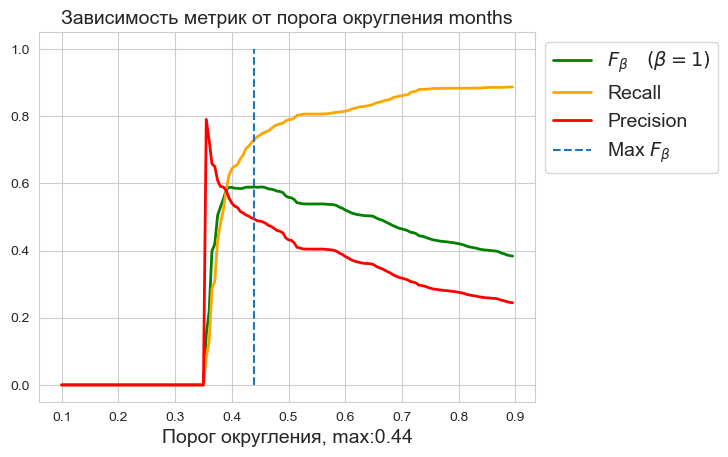

In [183]:
recalls = []
precisions = []
fbetas = []
accurs = []
aprcs = []
min_border = 0.1
max_border = 0.9
for edge in np.arange(min_border, max_border, 0.005):
    preds = (lgbm_best_month.predict_proba(X_test)[:,0] <= edge)
    recalls.append(recall_score(y_test_month, preds))
    precisions.append(precision_score(y_test_month, preds))
    accurs.append(accuracy_score(y_test_month, preds))
    fbetas.append(fbeta_score(y_test_month, preds, beta=1))
    aprcs.append(average_precision_score(y_test_month, preds))

maxarg = np.arange(min_border, max_border, 0.005)[np.argmax(fbetas)]
max_val = np.max(fbetas)

sns.set_style("whitegrid")
plt.plot(np.arange(min_border, max_border, 0.005), fbetas, label=r"$F_\beta \quad (\beta=1)$",linewidth=2.0, color = 'green')
plt.plot(np.arange(min_border, max_border, 0.005), recalls, label="Recall",linewidth=2.0, color='orange')
plt.plot(np.arange(min_border, max_border, 0.005), precisions, label="Precision",linewidth=2.0, color='red')
plt.plot([maxarg, maxarg], [0, 1], "--", label=r'Max $F_\beta$')
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.title("Зависимость метрик от порога округления months", fontsize=14)
plt.xlabel(f"Порог округления, max:{round(maxarg, 2)}", fontsize=14)
plt.show()

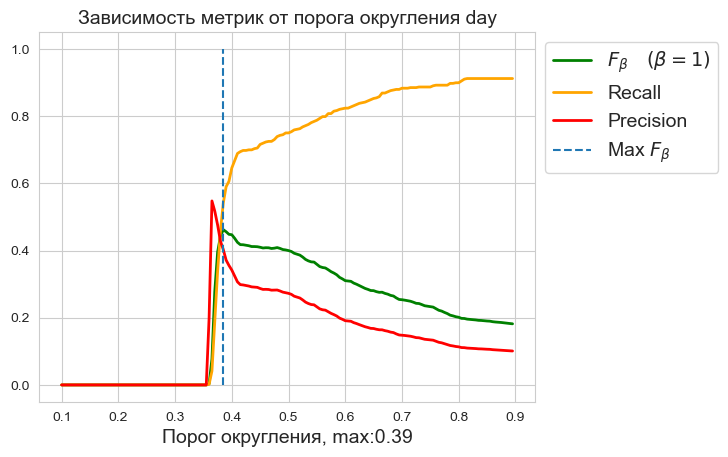

In [184]:
recalls = []
precisions = []
fbetas = []
accurs = []
aprcs = []
min_border = 0.1
max_border = 0.9
for edge in np.arange(min_border, max_border, 0.005):
    preds = (lgbm_best_day.predict_proba(X_test)[:,0] <= edge)
    recalls.append(recall_score(y_test_day, preds))
    precisions.append(precision_score(y_test_day, preds))
    accurs.append(accuracy_score(y_test_day, preds))
    fbetas.append(fbeta_score(y_test_day, preds, beta=1))
    aprcs.append(average_precision_score(y_test_day, preds))

maxarg = np.arange(min_border, max_border, 0.005)[np.argmax(fbetas)]
max_val = np.max(fbetas)

sns.set_style("whitegrid")
plt.plot(np.arange(min_border, max_border, 0.005), fbetas, label=r"$F_\beta \quad (\beta=1)$",linewidth=2.0, color = 'green')
plt.plot(np.arange(min_border, max_border, 0.005), recalls, label="Recall",linewidth=2.0, color='orange')
plt.plot(np.arange(min_border, max_border, 0.005), precisions, label="Precision",linewidth=2.0, color='red')
plt.plot([maxarg, maxarg], [0, 1], "--", label=r'Max $F_\beta$')
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.title("Зависимость метрик от порога округления day", fontsize=14)
plt.xlabel(f"Порог округления, max:{round(maxarg, 2)}", fontsize=14)
plt.show()

### Отбор признаков

Месяц

In [222]:
X_sfs = X_train.copy()
y_sfs = y_train_month.copy()

In [226]:
lgbm_month = LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=50, num_leaves=25, random_state=239, is_unbalance=True)

In [227]:
sfs = SFS(lgbm_month, k_features=X_sfs.shape[1], forward=True, scoring=fbeta)
sfs1 = sfs.fit(X_sfs, y_sfs)

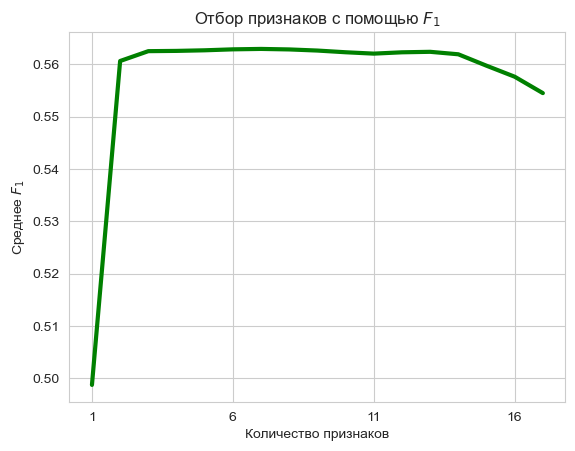

In [247]:
avg_fbetas_month = np.array([sfs1.subsets_[x]['avg_score'] for x in sfs1.subsets_])
plt.plot(range(1, len(avg_fbetas_month)+1), avg_fbetas_month, linewidth=3.0, color='green')
plt.xlabel("Количество признаков")
plt.ylabel(r"Среднее $F_1$")
plt.title(r"Отбор признаков с помощью $F_1$")
plt.xticks(range(1, len(avg_fbetas_month)+1, 5))
plt.show()

In [233]:
# Полезные фичи
list(sfs.subsets_[13]['feature_names'])

['days_since_last_deprep',
 'days_to_planrep',
 'ost_prob',
 'isload',
 'probeg_changes_min',
 'last_fr',
 'most_freq_fr',
 'num_rem',
 'days_since_last_trem',
 'rodid',
 'cnsi_volumek',
 'kuzov',
 'norma_km']

## Обучение до марта

In [30]:
path_test = '/Users/taisiapimenova/Documents/hackaton/test'

In [31]:
dislok2 = pd.read_parquet(path_test + '/dislok_wagons.parquet').convert_dtypes()

tr_rem2 = pd.read_parquet(path_test + '/tr_rems.parquet').convert_dtypes()

In [32]:
full_dislok = pd.concat([dislok, dislok2])
full_trem = pd.concat([tr_rem, tr_rem2])

In [145]:
TARGET = pd.read_csv(path_train + '/target/y_predict.csv')
TARGET['month'] = pd.to_datetime(TARGET['month'])

In [41]:
DF_PRED = get_sample(TARGET, full_dislok, full_trem, pred=True)

100%|████████████████████████████████████| 33707/33707 [04:09<00:00, 134.93it/s]


In [109]:
df_train_final = pd.concat([df, df_test])[sfs_features]
y_train_final_month = pd.concat([y_train_month, y_test_month])
y_train_final_day = pd.concat([y_train_day, y_test_day])

Месяц

In [316]:
lgbm_best_month = GridSearchCV(LGBMClassifier(is_unbalance=True), param_grid=grid, scoring=fbeta, cv=5)
lgbm_best_month.fit(df_train_final, y_train_final_month)

GridSearchCV(cv=5, estimator=LGBMClassifier(is_unbalance=True),
             param_grid={'learning_rate': [0.01, 0.1, 2],
                         'max_depth': [5, 15, -1],
                         'n_estimators': [20, 50, 100], 'num_leaves': [25, 40],
                         'random_state': [239]},
             scoring=make_scorer(fbeta_score, beta=1))

In [317]:
joblib.dump(lgbm_best_month, 'lgbm_best_month_final.pkl')

['lgbm_best_month_final.pkl']

Недели

In [318]:
lgbm_best_day = GridSearchCV(LGBMClassifier(is_unbalance=True), param_grid=grid, scoring=fbeta, cv=5)
lgbm_best_day.fit(df_train_final, y_train_final_day)

GridSearchCV(cv=5, estimator=LGBMClassifier(is_unbalance=True),
             param_grid={'learning_rate': [0.01, 0.1, 2],
                         'max_depth': [5, 15, -1],
                         'n_estimators': [20, 50, 100], 'num_leaves': [25, 40],
                         'random_state': [239]},
             scoring=make_scorer(fbeta_score, beta=1))

In [319]:
joblib.dump(lgbm_best_day, 'lgbm_best_day_final.pkl') 

['lgbm_best_day_final.pkl']

### Предсказание

In [165]:
final_pred = DF_PRED[['wagnum', 'date']].rename(columns={'date': 'month'}).copy()

final_pred['target_month'] = lgbm_best_month.predict(DF_PRED[sfs_features])
final_pred['target_day'] = lgbm_best_day.predict(DF_PRED[sfs_features])
final_pred = TARGET.iloc[:, :2].merge(final_pred, on=['wagnum', 'month'])

final_pred.to_csv("FINAL_PRED.csv")

## Интерпретация

In [15]:
explainer = shap.TreeExplainer(lgbm_best_month.best_estimator_)
shap_values = explainer.shap_values(df[sfs_features].iloc[:5000])

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
shap_values[1][0,:], df[sfs_features].iloc[1, :])

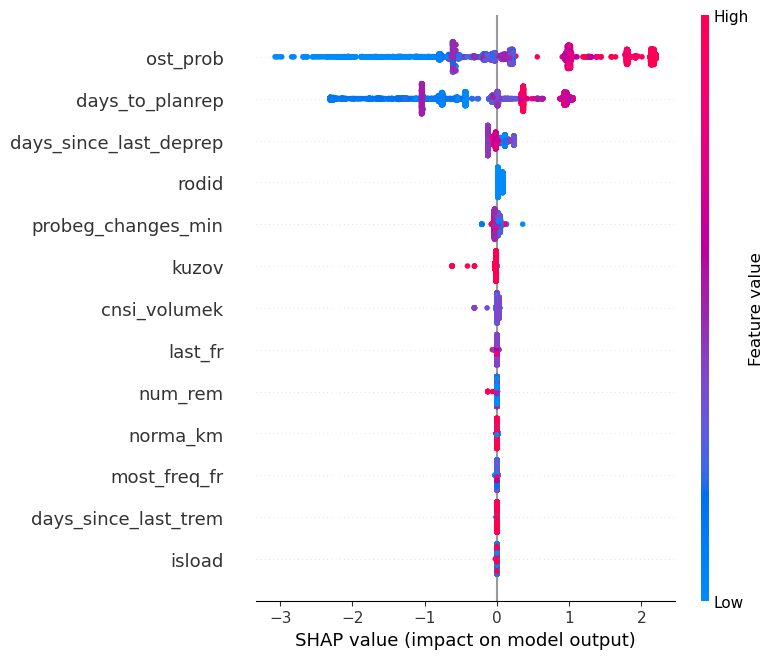

In [8]:
shap.summary_plot(shap_values[0], df[sfs_features].iloc[:5000])

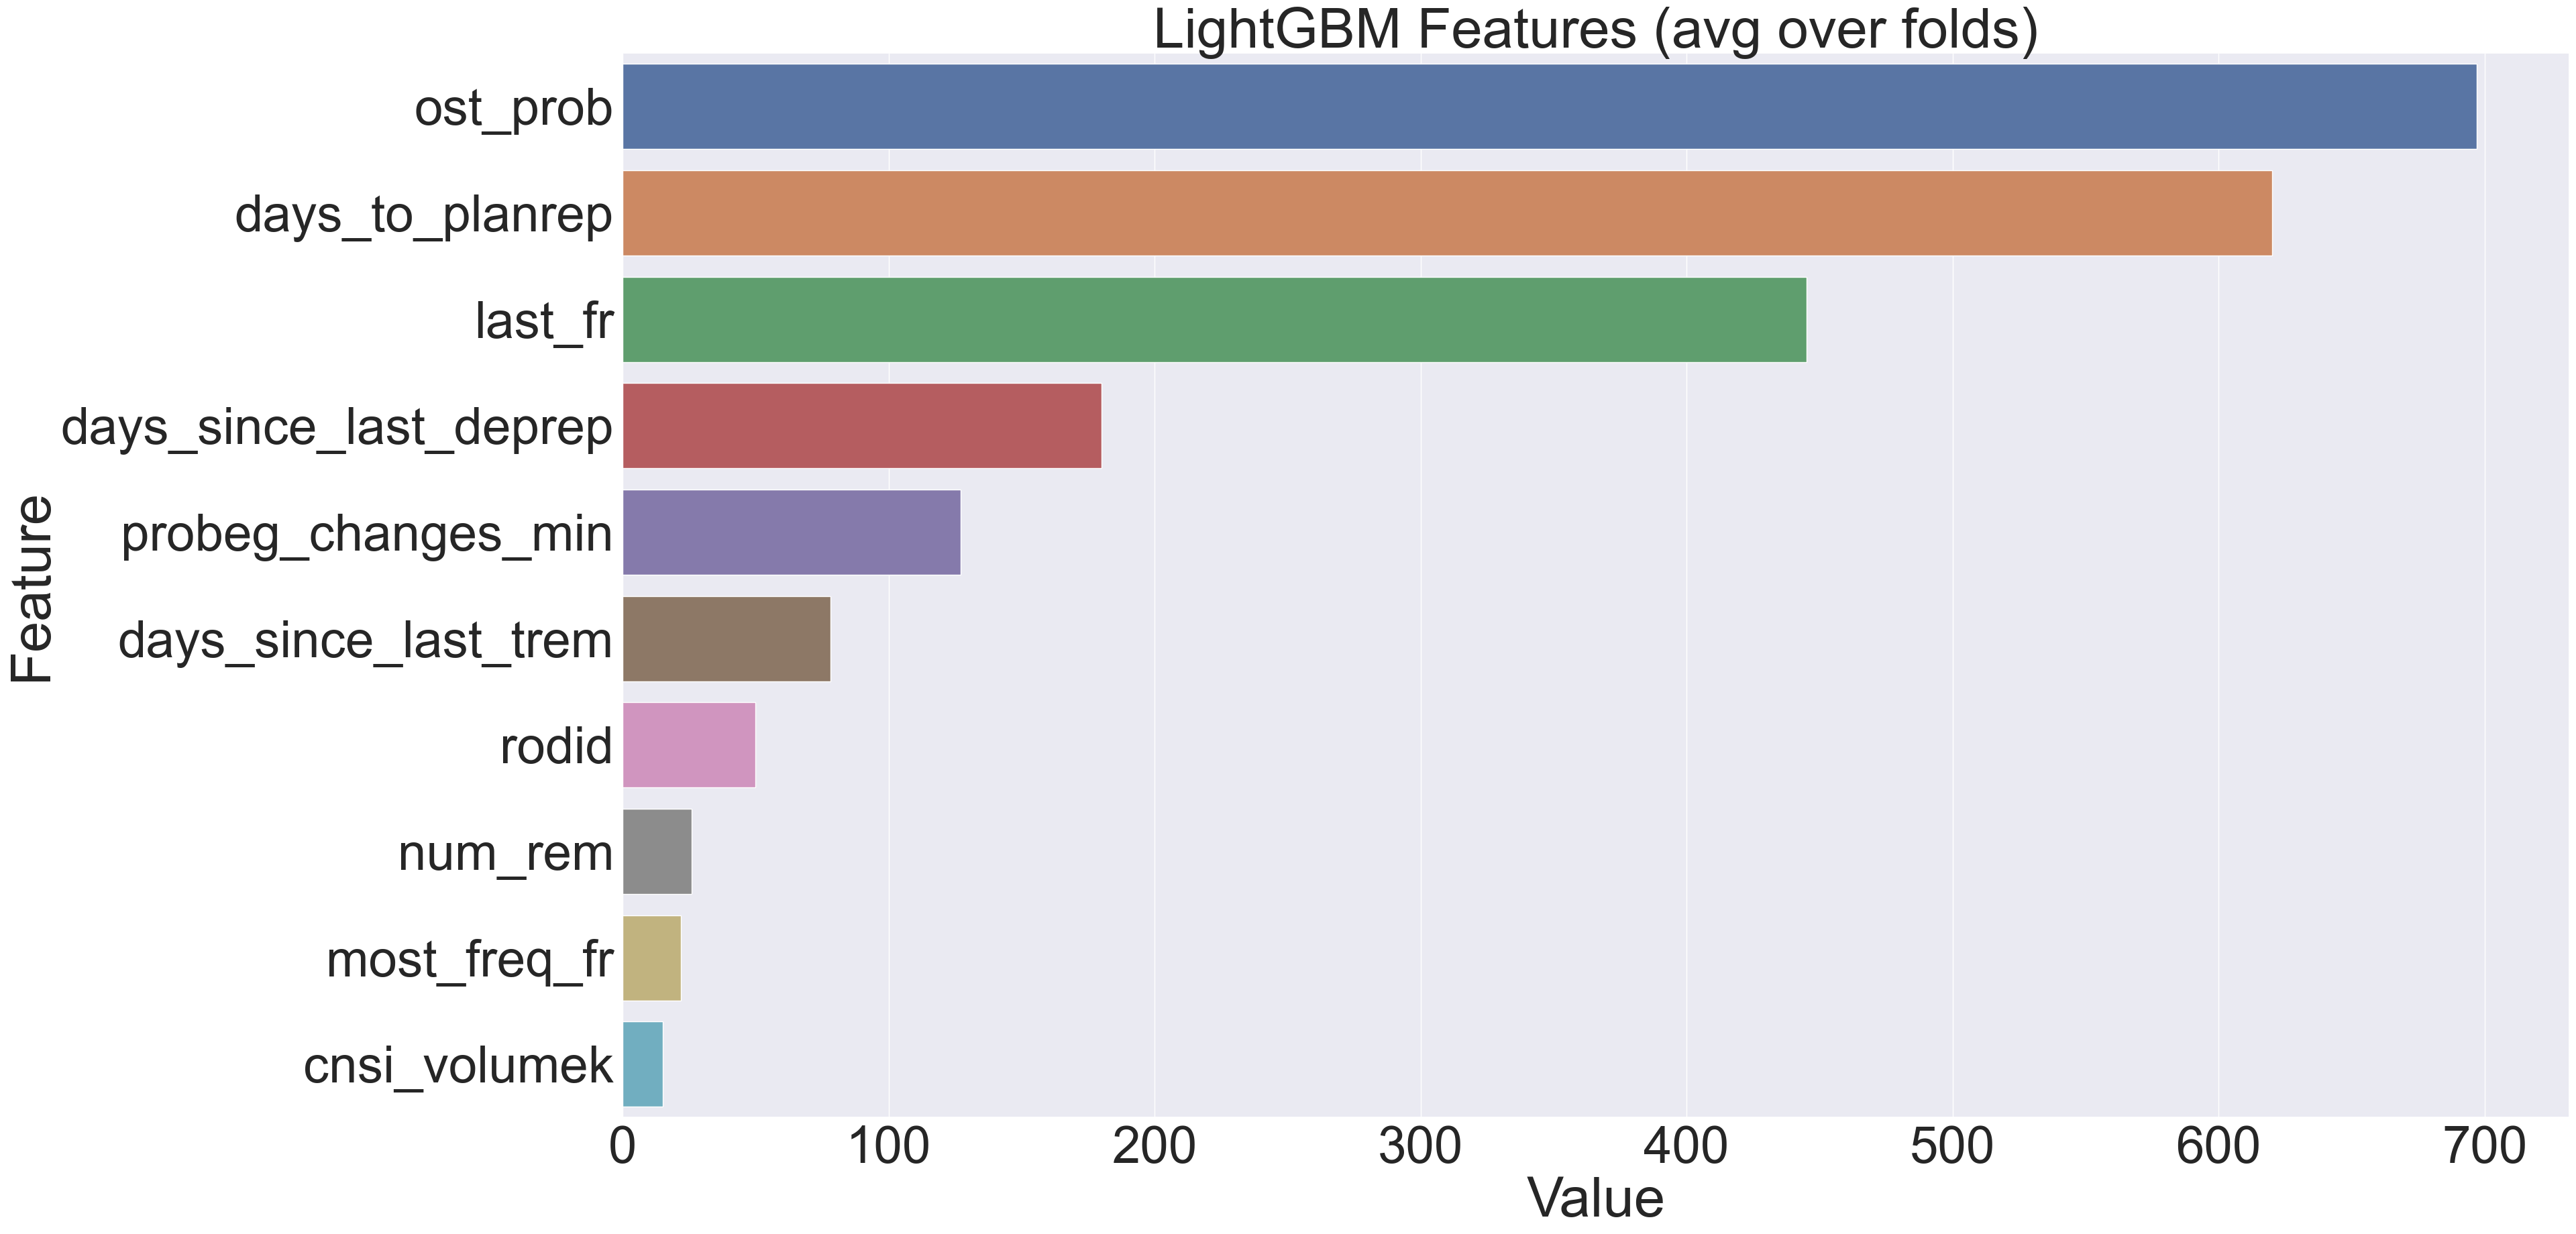

In [36]:
feature_imp = pd.DataFrame({'Value':lgbm_best_day.best_estimator_.feature_importances_,'Feature':df[sfs_features].columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()